In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
%matplotlib inline


#DATA preprocessing
#Load dataset
x_data = pd.read_csv(r'C:\Users\chongs\BDANALYSIS\furnace_bd.csv')
x_data = x_data.iloc[:,2:]
#epoch time 수정
x_data['3'] = x_data['3'].astype(str).str[:-3].astype(np.int64)
x_data['3'] = x_data['3'].astype(str).str[4:].astype(np.int64)

#구간 선택
x_data = x_data[x_data['3'].values > 890472]
x_data = x_data[x_data['3'].values < 899000]

#pivot table 사용 query 진행
x_data = x_data.pivot_table(index = x_data['3'],columns = x_data['1'])
#dataframe 재설정
x_data = x_data['2']
x_data = x_data.interpolate()

y_data = pd.read_csv(r"C:\Users\chongs\BDANALYSIS\14_Gls_org.csv", engine = 'python', index_col = False)
#원하는 columns 선택

y_data['time'] = y_data['날짜'] + ' ' + y_data['시간']

#시간 delay 수정 및 epoch 시간으로 convert
total_delay = dt.timedelta(minutes = 8, seconds=5)

y_data['time']=(pd.to_datetime(y_data['time']) - total_delay).apply(dt.datetime.timestamp).astype(np.int64)
y_data['time'] = y_data['time'].astype(str).str[4:].astype(np.int64)

y_data = y_data[['time','A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J','K', 'L', 'M', 'N', 'O']]

y_data.set_index('time', inplace = True)


# X, Y data의 index를 y_data의 인덱스에 맞춰 Join 실행(NaN 값 : drop)
xy = pd.concat([x_data, y_data], axis=1, join='inner', join_axes = [x_data.index] )
xy.dropna(inplace=True)

# X = xy[['linespeed', 'q2_gap', 'temp_zone6_bottom', 'temp_zone6_top',
#        'temp_zone7_10', 'temp_zone7_12', 'temp_zone7_14', 'temp_zone7_16',
#        'temp_zone7_4', 'temp_zone7_6', 'temp_zone7_8', 'temp_zone7_top',
#        'temp_zone8_25', 'temp_zone8_27', 'temp_zone8_29', 'temp_zone8_31',
#        'temp_zone8_33', 'temp_zone8_35', 'temp_zone8_37', 'temp_zone8_top',
#        'total_heat_kw']]

X = xy[['temp_zone7_10', 'temp_zone7_12', 'temp_zone7_14', 'temp_zone7_16',
       'temp_zone7_4', 'temp_zone7_6', 'temp_zone7_8', 'temp_zone8_25', 'temp_zone8_27', 'temp_zone8_29', 'temp_zone8_31',
       'temp_zone8_33', 'temp_zone8_35', 'temp_zone8_37'
       ]]
Y = xy[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
       'L', 'M', 'N', 'O']]

In [29]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
scaled_data = preprocessing.scale(X.T)
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals =1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

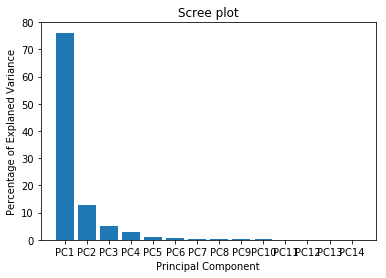

In [30]:
plt.bar(x = range(1, len(per_var)+1), height = per_var, tick_label = labels)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Explaned Variance')
plt.title('Scree plot')
plt.show()

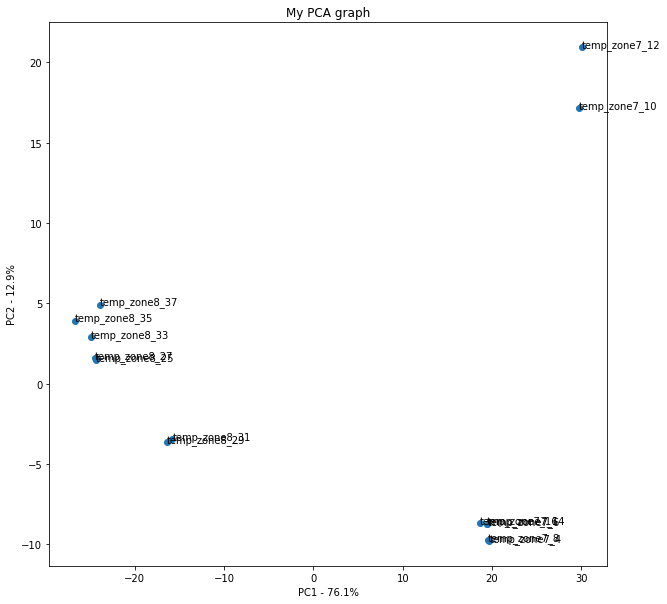

In [32]:
pca_df = pd.DataFrame(pca_data,index = ['temp_zone7_10', 'temp_zone7_12', 'temp_zone7_14', 'temp_zone7_16',
       'temp_zone7_4', 'temp_zone7_6', 'temp_zone7_8', 
       'temp_zone8_25', 'temp_zone8_27', 'temp_zone8_29', 'temp_zone8_31',
       'temp_zone8_33', 'temp_zone8_35', 'temp_zone8_37'], columns = labels )

fig = plt.figure(figsize = (10 , 10))
plt.scatter(pca_df.PC1, pca_df.PC2)


plt.title('My PCA graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

plt.show()

In [27]:
loading_scores = pd.Series(pca.components_[0])
sorted_loading_scores = loading_scores.abs().sort_values(ascending= True)
top_10_genes = sorted_loading_scores[0:10].index.values
print(loading_scores[top_10_genes])

191    0.000381
141    0.001096
188    0.002548
137   -0.002647
139    0.002700
178    0.003257
189    0.003301
138   -0.003353
140    0.003464
180    0.003509
dtype: float64
